## A robust WOE binning library

In [1]:
import pandas as pd
import operator
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import cross_val_score
import matplotlib.ticker as mtick

__author__ = 'Denis Surzhko'


# ver 0.2.2
# merge & _calc_stat bug fixes
class WoE:
    """
    Basic functionality for WoE bucketing of continuous and discrete variables
    :param self.bins: DataFrame WoE transformed variable and all related statistics
    :param self.iv: Information Value of the transformed variable
    """

    def __init__(self, qnt_num=16, min_block_size=16, spec_values=None, v_type='c', bins=None, t_type='b'):
        """
        :param qnt_num: Number of buckets (quartiles) for continuous variable split
        :param min_block_size: min number of obs in bucket (continuous variables), incl. optimization restrictions
        :param spec_values: List or Dictionary {'label': value} of special values (frequent items etc.)
        :param v_type: 'c' for continuous variable, 'd' - for discrete
        :param bins: Predefined bucket borders for continuous variable split
        :t_type : Binary 'b' or continous 'c' target variable
        :return: initialized class
        """
        self.__qnt_num = qnt_num  # Num of buckets/quartiles
        self._predefined_bins = None if bins is None else np.array(bins)  # user bins for continuous variables
        self.v_type = v_type  # if 'c' variable should be continuous, if 'd' - discrete
        self._min_block_size = min_block_size  # Min num of observation in bucket
        self._gb_ratio = None  # Ratio of good and bad in the sample
        self.bins = None  # WoE Buckets (bins) and related statistics
        self.df = None  # Training sample DataFrame with initial data and assigned woe
        self.qnt_num = None  # Number of quartiles used for continuous part of variable binning
        self.t_type = t_type  # Type of target variable
        if type(spec_values) == dict:  # Parsing special values to dict for cont variables
            self.spec_values = {}
            for k, v in spec_values.items():
                if v.startswith('d_'):
                    self.spec_values[k] = v
                else:
                    self.spec_values[k] = 'd_' + v
        else:
            if spec_values is None:
                self.spec_values = {}
            else:
                self.spec_values = {i: 'd_' + str(i) for i in spec_values}

    def fit(self, x, y):
        """
        Fit WoE transformation
        :param x: continuous or discrete predictor
        :param y: binary target variable
        :return: WoE class
        """
        # Data quality checks
        if not isinstance(x, pd.Series):
            x = pd.Series(x)
        if not isinstance(y, pd.Series):
            y = pd.Series(y)
        if not x.size == y.size:
            raise Exception("Y size don't match Y size")
        # Calc total good bad ratio in the sample
        t_bad = np.sum(y)
        if t_bad == 0 or t_bad == y.size:
            raise ValueError("There should be BAD and GOOD observations in the sample")
        if np.max(y) > 1 or np.min(y) < 0:
            raise ValueError("Y range should be between 0 and 1")
        # setting discrete values as special values
        if self.v_type == 'd':
            sp_values = {i: 'd_' + str(i) for i in x.unique()}
            if len(sp_values) > 100:
                raise type("DiscreteVarOverFlowError", (Exception,),
                           {"args": ('Discrete variable with too many unique values (more than 100)',)})
            else:
                if self.spec_values:
                    sp_values.update(self.spec_values)
                self.spec_values = sp_values
        # Make data frame for calculations
        df = pd.DataFrame({"X": x, "Y": y, 'order': np.arange(x.size)})
        # Separating NaN and Special values
        df_sp_values, df_cont = self._split_sample(df)
        # # labeling data
        df_cont, c_bins = self._cont_labels(df_cont)
        df_sp_values, d_bins = self._disc_labels(df_sp_values)
        # getting continuous and discrete values together
        self.df = df_sp_values.append(df_cont)
        self.bins = d_bins.append(c_bins)
        # calculating woe and other statistics
        self._calc_stat()
        # sorting appropriately for further cutting in transform method
        self.bins.sort_values('bins', inplace=True)
        # returning to original observation order
        self.df.sort_values('order', inplace=True)
        self.df.set_index(x.index, inplace=True)
        return self

    def fit_transform(self, x, y):
        """
        Fit WoE transformation
        :param x: continuous or discrete predictor
        :param y: binary target variable
        :return: WoE transformed variable
        """
        self.fit(x, y)
        return self.df['woe']

    def _split_sample(self, df):
        if self.v_type == 'd':
            return df, None
        sp_values_flag = df['X'].isin(self.spec_values.keys()).values | df['X'].isnull().values
        df_sp_values = df[sp_values_flag].copy()
        df_cont = df[np.logical_not(sp_values_flag)].copy()
        return df_sp_values, df_cont

    def _disc_labels(self, df):
        df['labels'] = df['X'].apply(
            lambda x: self.spec_values[x] if x in self.spec_values.keys() else 'd_' + str(x))
        d_bins = pd.DataFrame({"bins": df['X'].unique()})
        d_bins['labels'] = d_bins['bins'].apply(
            lambda x: self.spec_values[x] if x in self.spec_values.keys() else 'd_' + str(x))
        return df, d_bins

    def _cont_labels(self, df):
        # check whether there is a continuous part
        if df is None:
            return None, None
        # Max buckets num calc
        self.qnt_num = int(np.minimum(df['X'].unique().size / self._min_block_size, self.__qnt_num)) + 1
        # cuts - label num for each observation, bins - quartile thresholds
        bins = None
        cuts = None
        if self._predefined_bins is None:
            try:
                cuts, bins = pd.qcut(df["X"], self.qnt_num, retbins=True, labels=False)
            except ValueError as ex:
                if ex.args[0].startswith('Bin edges must be unique'):
                    ex.args = ('Please reduce number of bins or encode frequent items as special values',) + ex.args
                    raise
            bins = np.append((-float("inf"),), bins[1:-1])
        else:
            bins = self._predefined_bins
            if bins[0] != float("-Inf"):
                bins = np.append((-float("inf"),), bins)
            cuts = pd.cut(df['X'], bins=np.append(bins, (float("inf"),)),
                          labels=np.arange(len(bins)).astype(str))
        df["labels"] = cuts.astype(str)
        c_bins = pd.DataFrame({"bins": bins, "labels": np.arange(len(bins)).astype(str)})
        return df, c_bins

    def _calc_stat(self):
        # calculating WoE
        col_names = {'count_nonzero': 'bad', 'size': 'obs'}
        stat = self.df.groupby("labels")['Y'].agg([np.mean, np.count_nonzero, np.size]).rename(columns=col_names).copy()
        if self.t_type != 'b':
            stat['bad'] = stat['mean'] * stat['obs']
        stat['good'] = stat['obs'] - stat['bad']
        t_good = np.maximum(stat['good'].sum(), 0.5)
        t_bad = np.maximum(stat['bad'].sum(), 0.5)
        stat['woe'] = stat.apply(self._bucket_woe, axis=1) + np.log(t_bad / t_good)
        iv_stat = (stat['good'] / t_good - stat['bad'] / t_bad) * stat['woe']
        self.iv = iv_stat.sum()
        # adding stat data to bins
        self.bins = pd.merge(stat, self.bins, left_index=True, right_on=['labels'])
        label_woe = self.bins[['woe', 'labels']].drop_duplicates()
        self.df = pd.merge(self.df, label_woe, left_on=['labels'], right_on=['labels'], how='left')

    def transform(self, x, manual_woe=None, replace_missing=None):
        """
        Transforms input variable according to previously fitted rule
        :param x: input variable
        :param manual_woe: one can change fitted woe with manual values by providing dict {label: new_woe_value}
        :replace_missing: replace woe for labels not observable in traning dataset by this value
        :return: DataFrame with transformed with original and transformed variables
        """
        if not isinstance(x, pd.Series):
            raise TypeError("pandas.Series type expected")
        if self.bins is None:
            raise Exception('Fit the model first, please')
        df = pd.DataFrame({"X": x, 'order': np.arange(x.size)})
        # splitting to discrete and continous pars
        df_sp_values, df_cont = self._split_sample(df)
        # Replacing original with manual woe
        tr_bins = self.bins[['woe', 'labels']].copy()
        if manual_woe:
            if not type(manual_woe) == dict:
                TypeError("manual_woe should be dict")
            else:
                for key in manual_woe:
                    tr_bins['woe'].mask(tr_bins['labels'] == key, manual_woe[key], inplace=True)

        if replace_missing is not None:
            tr_bins = tr_bins.append({'labels': 'd__transform_missing_replacement__', 'woe': replace_missing},
                                     ignore_index=True)

        # function checks existence of special values, raises error if sp do not exist in training set
        def get_sp_label(x_):
            if x_ in self.spec_values.keys():
                return self.spec_values[x_]
            else:
                str_x = 'd_' + str(x_)
                if str_x in list(self.bins['labels']):
                    return str_x
                else:
                    if replace_missing is not None:
                        return 'd__transform_missing_replacement__'
                    else:
                        raise ValueError('Value {} does not exist in the training set'.format(str_x))

        # assigning labels to discrete part
        df_sp_values['labels'] = df_sp_values['X'].apply(get_sp_label)
        # assigning labels to continuous part
        c_bins = self.__get_cont_bins()
        if self.v_type != 'd':
            cuts = pd.cut(df_cont['X'], bins=np.append(c_bins["bins"], (float("inf"),)), labels=c_bins["labels"])
            df_cont['labels'] = cuts.astype(str)
        # Joining continuous and discrete parts
        df = df_sp_values.append(df_cont)
        # assigning woe
        df = pd.merge(df, tr_bins[['woe', 'labels']].drop_duplicates(), left_on=['labels'], right_on=['labels'])
        # returning to original observation order
        df.sort_values('order', inplace=True)
        return df.set_index(x.index)

    def __get_cont_bins(self):
        """
        Helper function
        :return: return continous part of self.bins
        """
        return self.bins[self.bins['labels'].apply(lambda z: not z.startswith('d_'))]

    def merge(self, label1, label2=None):
        """
        Merge of buckets with given labels
        In case of discrete variable, both labels should be provided. As the result labels will be marget to one bucket.
        In case of continous variable, only label1 should be provided. It will be merged with the next label.
        :param label1: first label to merge
        :param label2: second label to merge
        :return:
        """
        spec_values = self.spec_values.copy()
        c_bins = self.__get_cont_bins().copy()
        if label2 is None and not label1.startswith('d_'):  # removing bucket for continuous variable
            c_bins = c_bins[c_bins['labels'] != label1]
        else:
            if not (label1.startswith('d_') and label2.startswith('d_')):
                raise Exception('Labels should be discrete simultaneously')
            for i in self.bins.loc[self.bins['labels'].isin([label1, label2]), 'bins']:
                spec_values[i] = label1 + '_' + label2

        new_woe = WoE(self.__qnt_num, self._min_block_size, spec_values, self.v_type, c_bins['bins'], self.t_type)
        return new_woe.fit(self.df['X'], self.df['Y'])

    def force_monotonic(self, hypothesis=0):
        """
        Makes transformation monotonic if possible, given relationship hypothesis (otherwise - MonotonicConstraintError
        exception)
        :hypothesis: direct (0) or inverse (1) hypothesis relationship between predictor and target variable
        :return: new WoE object with monotonic transformation
        """
        if hypothesis == 0:
            op_func = operator.gt
        else:
            op_func = operator.lt
        cont_bins = self.__get_cont_bins()
        new_woe = self
        for i, w in enumerate(cont_bins[1:]['woe']):
            if op_func(cont_bins.iloc[i].loc['woe'], w):
                if cont_bins.shape[0] < 3:
                    raise type("MonotonicConstraintError", (Exception,),
                               {"args": ('Impossible to force Monotonic Constraint',)})
                else:
                    new_woe = self.merge(cont_bins.iloc[i+1].loc['labels'])
                    new_woe = new_woe.force_monotonic(hypothesis)
                    return new_woe
        return new_woe

    def plot(self, sort_values=True, labels=False):
        """
        Plot WoE transformation and default rates
        :param sort_values: whether to sort discrete variables by woe, continuous by labels
        :param labels: plot labels or intervals for continuous buckets
        :return: plotting object
        """
        bar_width = 0.8
        woe_fig = plt.figure()
        plt.title('Number of Observations and WoE per bucket')
        ax = woe_fig.add_subplot(111)
        ax.set_ylabel('Observations')
        plot_data = self.bins[['labels', 'woe', 'obs', 'bins']].copy().drop_duplicates()

        # creating plot labels
        if self.v_type != 'd':
            cont_labels = plot_data['labels'].apply(lambda z: not z.startswith('d_'))
            plot_data['plot_bins'] = plot_data['bins'].apply(lambda x: '{:0.2g}'.format(x))
            temp_data = plot_data[cont_labels].copy()

            right_bound = temp_data['plot_bins'].iloc[1:].append(pd.Series(['Inf']))
            temp_data['plot_bins'] = temp_data['plot_bins'].add(' : ').add(list(right_bound))

            plot_data = temp_data.append(plot_data[~cont_labels])
            cont_labels = plot_data['labels'].apply(lambda z: not z.startswith('d_'))
            plot_data['plot_bins'] = np.where(cont_labels, plot_data['plot_bins'], plot_data['labels'])
        else:
            plot_data['plot_bins'] = plot_data['bins']

        # sorting
        if sort_values:
            if self.v_type != 'd':
                cont_labels = plot_data['labels'].apply(lambda z: not z.startswith('d_'))
                temp_data = plot_data[cont_labels].sort_values('bins')
                plot_data = temp_data.append(plot_data[~cont_labels].sort_values('labels'))
            else:
                plot_data.sort_values('woe', inplace=True)

        # start plotting
        index = np.arange(plot_data.shape[0])
        plt.xticks(index, plot_data['labels'] if labels else plot_data['plot_bins'])
        plt.bar(index, plot_data['obs'], bar_width, color='b', label='Observations')
        ax2 = ax.twinx()
        ax2.set_ylabel('Weight of Evidence')
        ax2.plot(index, plot_data['woe'], 'bo-', linewidth=4.0, color='r', label='WoE')
        handles1, labels1 = ax.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles = handles1 + handles2
        labels = labels1 + labels2
        plt.legend(handles, labels)
        woe_fig.autofmt_xdate()
        return woe_fig

    def optimize(self, criterion=None, fix_depth=None, max_depth=None, cv=3, scoring=None, min_samples_leaf=None):
        """
        WoE bucketing optimization (continuous variables only)
        :param criterion: binary tree split criteria
        :param fix_depth: use tree of a fixed depth (2^fix_depth buckets)
        :param max_depth: maximum tree depth for a optimum cross-validation search
        :param cv: number of cv buckets
        :param scoring: scorer for cross_val_score
        :param min_samples_leaf: minimum number of observations in each of optimized buckets
        :return: WoE class with optimized continuous variable split
        """
        if self.t_type == 'b':
            tree_type = tree.DecisionTreeClassifier
        else:
            tree_type = tree.DecisionTreeRegressor
        m_depth = int(np.log2(self.__qnt_num)) + 1 if max_depth is None else max_depth
        cont = self.df['labels'].apply(lambda z: not z.startswith('d_'))
        x_train = np.array(self.df[cont]['X'])
        y_train = np.array(self.df[cont]['Y'])
        x_train = x_train.reshape(x_train.shape[0], 1)
        if not min_samples_leaf:
            min_samples_leaf = self._min_block_size
        start = 1
        cv_scores = []
        if fix_depth is None:
            for i in range(start, m_depth):
                if criterion is None:
                    d_tree = tree_type(max_depth=i, min_samples_leaf=min_samples_leaf)
                else:
                    d_tree = tree_type(criterion=criterion, max_depth=i, min_samples_leaf=min_samples_leaf)
                scores = cross_val_score(d_tree, x_train, y_train, cv=cv, scoring=scoring)
                cv_scores.append(scores.mean())
            best = np.argmax(cv_scores) + start
        else:
            best = fix_depth
        final_tree = tree_type(max_depth=best, min_samples_leaf=min_samples_leaf)
        final_tree.fit(x_train, y_train)
        opt_bins = final_tree.tree_.threshold[final_tree.tree_.feature >= 0]
        opt_bins = np.sort(opt_bins)
        new_woe = WoE(self.__qnt_num, self._min_block_size, self.spec_values, self.v_type, opt_bins, self.t_type)
        return new_woe.fit(self.df['X'], self.df['Y'])

    @staticmethod
    def _bucket_woe(x):
        t_bad = x['bad']
        t_good = x['good']
        t_bad = 0.5 if t_bad == 0 else t_bad
        t_good = 0.5 if t_good == 0 else t_good
        return np.log(t_good / t_bad)


def plot_woe_graph(df, label, iv):
  x = df['labels']
  y = df['obs']
  z = df['mean']

  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax2 = ax.twinx()

  ax.bar(x, y, label = 'Count')
  ax2.plot(x, z, label = 'Default rate', color='red', linewidth=2.5)
  fig.legend(bbox_to_anchor=(0.7, -0.15), 
            loc="lower right",
            bbox_transform=fig.transFigure, 
            ncol=2, 
            frameon=False)
  ax.set_xlabel(f"Bin's left edge")
  ax.set_ylabel(r"Observations")
  ax2.set_ylabel(r"Default rate")

  ax.set_xticklabels(woe.bins['bins'].round(2).apply(str), rotation=45)
  ax2.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=2))

  plt.title(f"{label} (IV: {iv:.2%})", fontsize=12, x=0.5, y=1.05)

  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:292: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


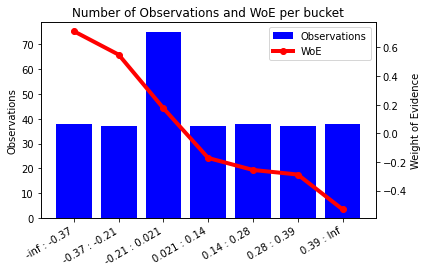

In [2]:
# Set target type: 'b' for default/non-default, 'c' for continous pd values
t_type_ = 'c'
N = 300

# Random variables
x1 = np.random.rand(N) - 0.5
x2 = np.random.rand(N) - 0.5
if t_type_ == 'b':
    y_ = np.where(np.random.rand(N, ) + x1 + x2 > 2, 1, 0)
else:
    y_ = np.random.rand(N) + x1 + x2
    y_ = (y_ - np.min(y_)) / (np.max(y_) - np.min(y_)) / 2

# Initialize WoE object
woe_def = WoE()
woe = WoE(7, 30, v_type='c', t_type=t_type_)

# Transform x1
woe.fit(pd.Series(x1), pd.Series(y_))

# make monotonic transformation with decreasing relationship hypothesis
woe_monotonic = woe.force_monotonic(hypothesis=1)
fig = woe_monotonic.plot()
plt.show(fig)

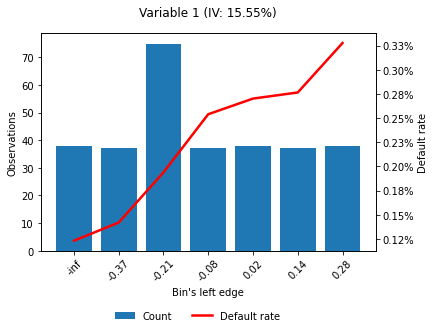

In [3]:
plot_woe_graph(woe_monotonic.bins, 'Variable 1', woe_monotonic.iv)

In [4]:
woe_monotonic.bins

,mean,bad,obs,good,woe,bins,labels
0,0.123070,4.676676,38,33.323324,0.713459,-inf,0
1,0.141879,5.249517,37,31.750483,0.549561,-0.374912,1
2,0.193824,14.536792,75,60.463208,0.175141,-0.208233,2
3,0.253929,9.395373,37,27.604627,-0.172445,0.021000,3
4,0.270114,10.264341,38,27.735659,-0.256168,0.138727,4
5,0.276439,10.228250,37,26.771750,-0.288018,0.277730,5
6,0.327582,12.448122,38,25.551878,-0.531070,0.390389,6


In [5]:
woe_monotonic.iv

0.1554805133582821